# **Импорт библиотек**

In [75]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [76]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [77]:
!pip freeze > requirements.txt

# **Читаем данные**

In [78]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [79]:
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(3))
print('Размерность тестового датасета: ', test.shape)
display(test.head(3))

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y


## Описания полей

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

In [80]:
# Информация о датасете 
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

None

В датасете test нет признака "default". Мы должны предсказать значение указанного признака, 
предварительно заполним его нулями.
Для корректной обработки признаков объединим датасеты train и test, 
предварительно в новой переменной "train" указав, какие записи относятся к датасету train.

In [81]:
test['default'] = 0 # заполняем признак нулями
test['train'] = 0 # указываем, что записи не принадлежат датасету train
train['train'] = 1 # указываем, что записи принадлежат датасету train
data = pd.concat([train, test], ignore_index=True) # объединяем датасеты в один


# **Предварительный анализ данных**

In [82]:
# смотрим на данные в датасете
display(data)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,0,0
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,0,0
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,0,0
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,0,0


In [83]:
# смотрим на информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

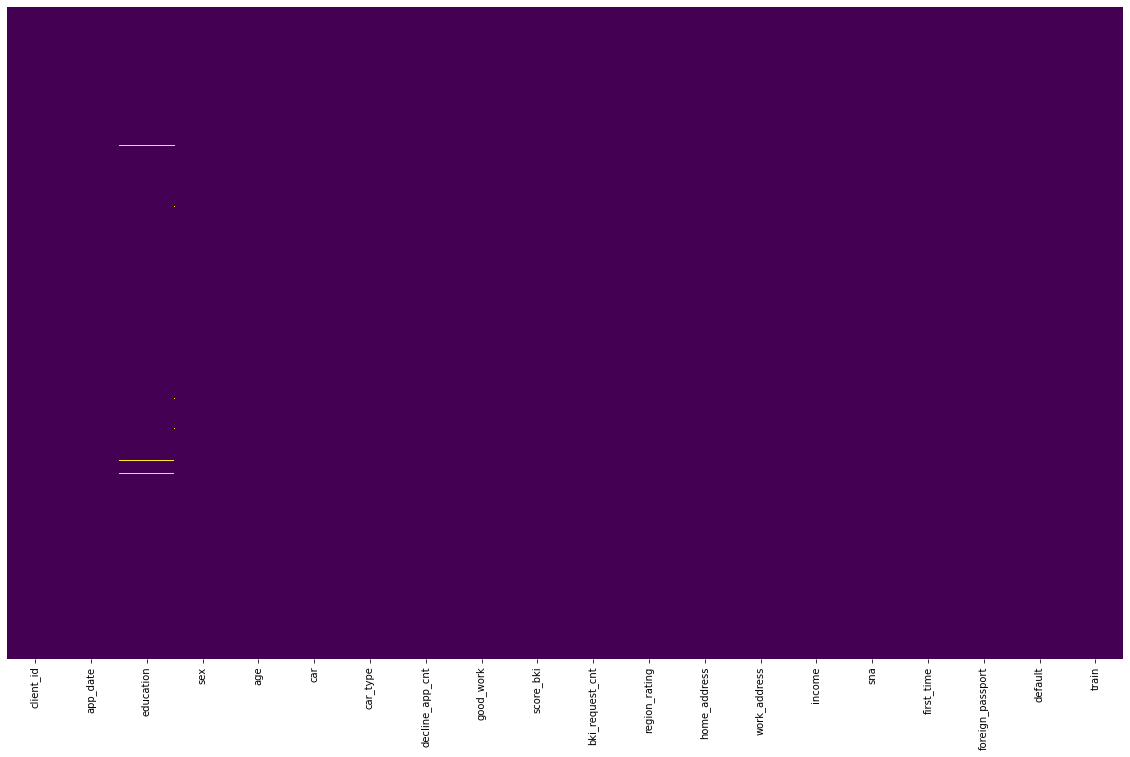

In [84]:
#Работа с пропусками
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

<AxesSubplot:>

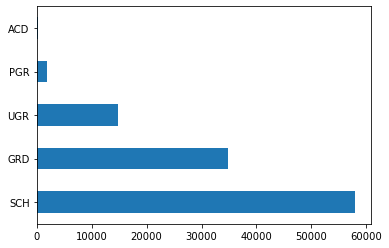

In [85]:
# определяем наиболее часто встречающимся значением в признаке 'education'
data['education'].value_counts().plot.barh() 

In [86]:
# заполням пропущенные значения наиболее часто встречающимся "SCH"
data[data['education'].isnull()] = data[data['education'].isnull()].fillna('SCH')

In [87]:
# посмотрим количество уникальных значений в каждом признаке датасета
data.nunique()

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
default                  2
train                    2
dtype: int64

Выделим из датасета бинарные (за исключением 'default' и 'train'), категориальные 
и числовые признаки (за исключением 'client_id').

In [88]:
# бинарные признаки
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные признаки
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']
# числовые признаки
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income']

На этом предварительный анализ датасета закончим и перейдем к анализу непосредственно самих данных,
их преобразованию и созданию новых признаков.

# **Анализ и преобразование данных**

**Целевой признак 'default'**

Посмотрим на распределение целевого признака 'default' для записей из датасета 'train'

<AxesSubplot:xlabel='default', ylabel='count'>

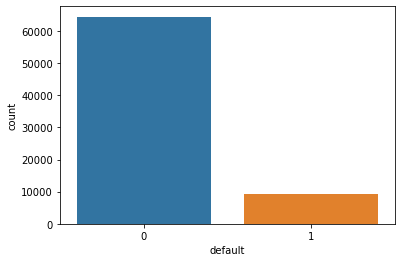

In [89]:
sns.countplot(x='default', data = data[data['train'] == 1])

Видим, что большинство значений в признаке равно нулю. Т.е. распределение несбалансированное.

**Признака 'app_date'**

Первый признак, который нас интересует - кол-во заявко поданных за каждый день рассматриваемого периода.

In [90]:
# пребразуем значения признака в формат datetime
data.app_date = pd.to_datetime(data.app_date)
data.app_date

0        2014-02-01
1        2014-03-12
2        2014-02-01
3        2014-01-23
4        2014-04-18
            ...    
110143   2014-03-31
110144   2014-04-25
110145   2014-03-30
110146   2014-01-07
110147   2014-03-17
Name: app_date, Length: 110148, dtype: datetime64[ns]

Рассмотрим датасет 'train'.

In [91]:
num_of_app_train = data['app_date'][data['train'] == 1].value_counts()
num_of_app_train

2014-03-18    1018
2014-03-17     911
2014-03-19     909
2014-03-31     904
2014-04-07     882
              ... 
2014-04-20     243
2014-01-07     228
2014-01-03     193
2014-01-02     137
2014-01-01      43
Name: app_date, Length: 120, dtype: int64

Посмотрим на распределение кол-ва заявок по дням.
Рассматриваем датасет 'train'.

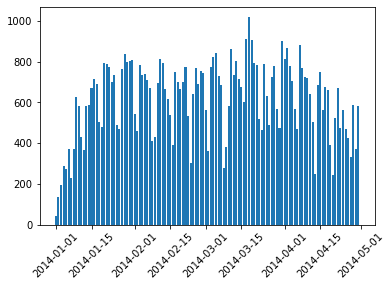

In [92]:
plt.bar(num_of_app_train.index, num_of_app_train)
plt.xticks(rotation=45)
plt.show()

По графику видно, что  начале года кол-во заявок росло. 
Ближе к концу рассматриваемого периода наметился тренд на снижение.

Следующий признак, который нас интересует - распределение дефолтов по дате подачи заявки.
Рассматриваем датасет 'train'.

In [93]:
num_of_def_train = data['app_date'][(data['train'] == 1) & (data['default'] == 1)].value_counts()

Посмотрим на распределение кол-ва дефолтов по дате выдачи заявки.
Рассматриваем для строк из датасета train.

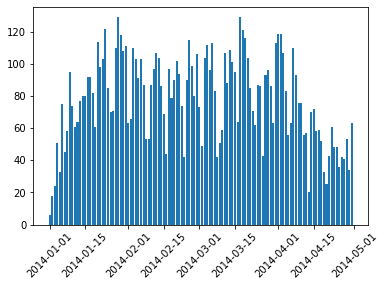

In [94]:
plt.bar(num_of_def_train.index, num_of_def_train)
plt.xticks(rotation=45)
plt.show()

По графику видно, что в начале кол-во дефолтов росло. 
Ближе к концу рассматриваемого периода наметился тренд на снижение.
Можно сделать вывод, что банк стал лучше работать со временем: он стал меньше выдавать потенциально проблемных кредитов и кол-во дефолтов снизилось.

Создадим новые признаки на основе признака 'app_date'.

In [95]:
# добавим в датасет кол-во заявок, поданных в каждую дату по данным датасета train
data['num_of_app'] = data['app_date'].replace(to_replace=num_of_app_train.to_dict())

# добавим в датасет кол-во дефолтов, на каждую дату поданной заявки по данным датасета train
data['num_of_def'] = data['app_date'].replace(to_replace=num_of_def_train.to_dict())

# на основе добавленных признаков создадим новый - доля дефолтов от кол-ва поданных заявок
data['per_of_def'] = data['num_of_def'] / data['num_of_app']
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,num_of_app,num_of_def,per_of_def
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1,542,63,0.116236
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1,737,88,0.119403
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1,542,63,0.116236
3,16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1,703,122,0.173542
4,101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1,661,52,0.078669


Уберем из датасета data кол-во дефолтов по данным датасета train, 
т.к. в новом датасете data картина может быть другой.

In [96]:
del data['num_of_def']

Также заменим значения в признаке кол-во заявок по данным датасета train на кол-во заявок 
в новом датасете data. (Т.е. по сути, добавим эту информацию для записей из датасета test.)

In [97]:
num_of_app_data = data['app_date'].value_counts()
data['num_of_app'] = data['app_date'].replace(to_replace=num_of_app_data.to_dict())

In [98]:
# добавим новые признаки 'per_of_def', 'num_of_app' в список числовых признаков
num_cols.append('per_of_def')
num_cols.append('num_of_app')

In [99]:
# проверяем, что признаки добавлены
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,num_of_app,per_of_def
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1,794,0.116236
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1,1110,0.119403
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1,794,0.116236
3,16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1,1060,0.173542
4,101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1,981,0.078669


**Категориальные признаки**

Категориальный признак "education":
SCH    39167
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64


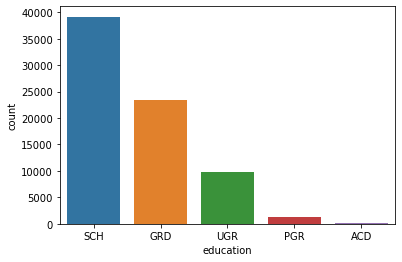

Категориальный признак "home_address":
2    39956
1    32585
3     1258
Name: home_address, dtype: int64


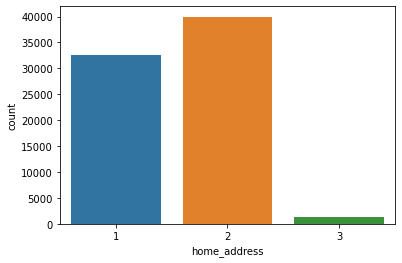

Категориальный признак "work_address":
3    44959
2    20506
1     8334
Name: work_address, dtype: int64


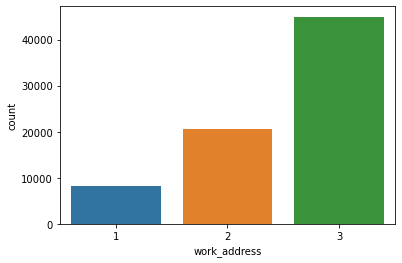

Категориальный признак "sna":
1    47301
4    11749
2    10626
3     4123
Name: sna, dtype: int64


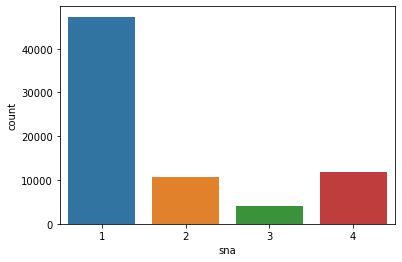

Категориальный признак "first_time":
3    31255
4    18737
1    12239
2    11568
Name: first_time, dtype: int64


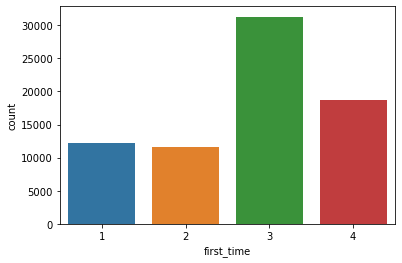

In [100]:
# рассматриваем для датасета train
for col in cat_cols:
    print('Категориальный признак "{a}":'.format(a=col)) # выводим название признака
    print(data[col][data['train'] == 1].value_counts()) # выводим уникальные значения и их количество
    # выводим распределение заемщиков по признакам
    plt.figure()
    sns.countplot(x=col, data = data[data['train'] == 1])
    plt.show()

Выводы:
в признаке "education" приходится малая доля на значения PGR и ACD,
в признаке "home_address" приходится малая доля на значение 3.
Для остальных признаков доля всех значений достаточно велика, но имется один ярко выраженный признак.

**Бинарные признаки**

Бинарный признак "sex":
F    41562
M    32237
Name: sex, dtype: int64


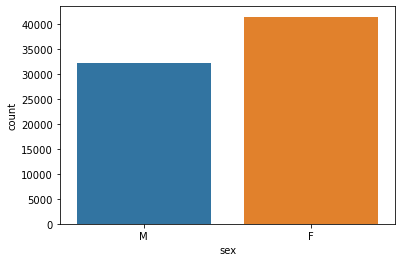

Бинарный признак "car":
N    49832
Y    23967
Name: car, dtype: int64


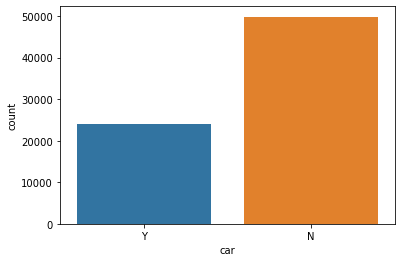

Бинарный признак "car_type":
N    59791
Y    14008
Name: car_type, dtype: int64


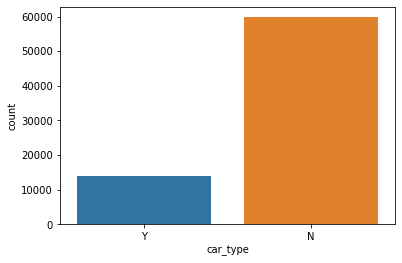

Бинарный признак "good_work":
0    61630
1    12169
Name: good_work, dtype: int64


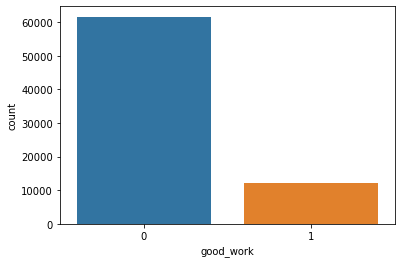

Бинарный признак "foreign_passport":
N    62733
Y    11066
Name: foreign_passport, dtype: int64


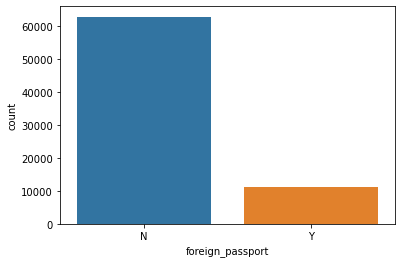

In [101]:
# рассматриваем для датасета train
for col in bin_cols:
    print('Бинарный признак "{a}":'.format(a=col)) # выводим название признака
    print(data[col][data['train'] == 1].value_counts()) # выводим уникальные значения и их количество
    # выводим распределение заемщиков по признакам
    plt.figure()
    sns.countplot(x=col, data = data[data['train'] == 1])
    plt.show()

Выводы:
в признаке "sex" значения распределены примерно поровну,
в остальных распределение неравномерно - имеется серьезное преобладание одного из признаков.

**Числовые признаки**

Числовой признак "age":
count    73799.000000
mean        39.280641
std         11.520378
min         21.000000
25%         30.000000
50%         37.000000
75%         48.000000
max         72.000000
Name: age, dtype: float64


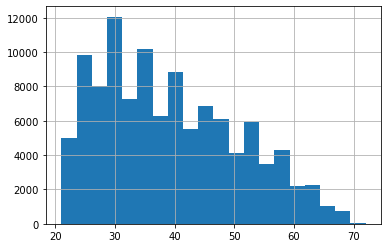

Числовой признак "decline_app_cnt":
count    73799.000000
mean         0.275749
std          0.804272
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         33.000000
Name: decline_app_cnt, dtype: float64


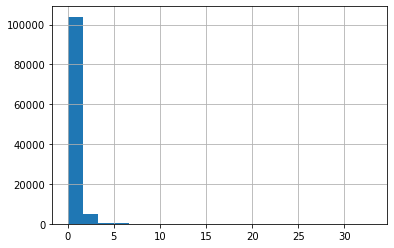

Числовой признак "score_bki":
count    73799.000000
mean        -1.904724
std          0.498231
min         -3.624586
25%         -2.259534
50%         -1.920823
75%         -1.569831
max          0.199773
Name: score_bki, dtype: float64


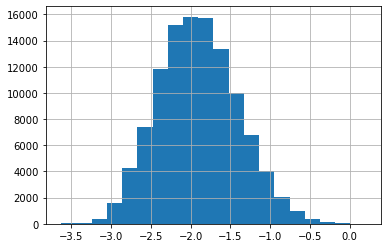

Числовой признак "bki_request_cnt":
count    73799.000000
mean         2.000339
std          2.252073
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         53.000000
Name: bki_request_cnt, dtype: float64


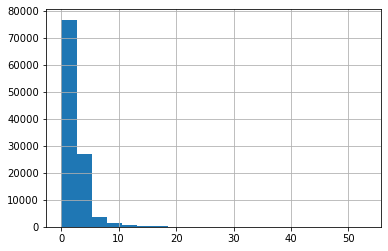

Числовой признак "region_rating":
count    73799.000000
mean        56.725701
std         13.055717
min         20.000000
25%         50.000000
50%         50.000000
75%         60.000000
max         80.000000
Name: region_rating, dtype: float64


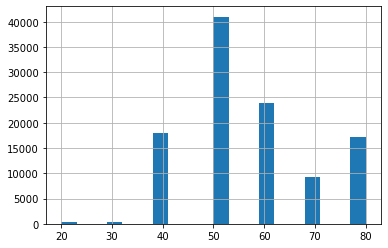

Числовой признак "income":
count      73799.000000
mean       41099.775417
std        46166.322400
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64


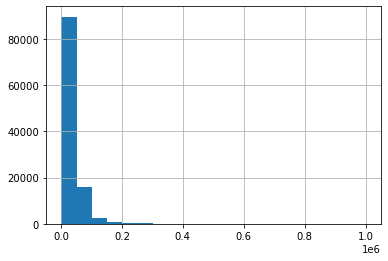

Числовой признак "per_of_def":
count    73799.000000
mean         0.126994
std          0.020828
min          0.076596
25%          0.115489
50%          0.129464
75%          0.140306
max          0.203252
Name: per_of_def, dtype: float64


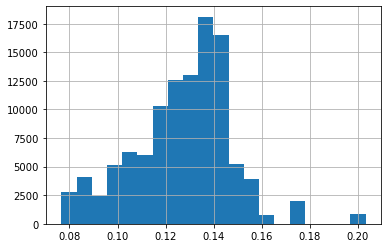

Числовой признак "num_of_app":
count    73799.000000
mean      1003.073212
std        235.056937
min         56.000000
25%        848.000000
50%       1071.000000
75%       1173.000000
max       1491.000000
Name: num_of_app, dtype: float64


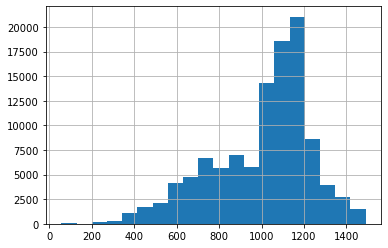

In [102]:
# рассматриваем для датасета train
for col in num_cols:
    print('Числовой признак "{a}":'.format(a=col)) # выводим название признака
    print(data[col][data['train'] == 1].describe())
    # выводим распределение заемщиков по признакам
    data[col].hist(bins=20)
    plt.show()

Числовой признак "age":
count    73799.000000
mean        39.280641
std         11.520378
min         21.000000
25%         30.000000
50%         37.000000
75%         48.000000
max         72.000000
Name: age, dtype: float64


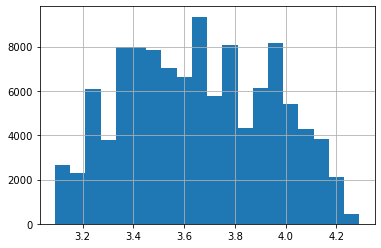

Числовой признак "decline_app_cnt":
count    73799.000000
mean         0.275749
std          0.804272
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         33.000000
Name: decline_app_cnt, dtype: float64


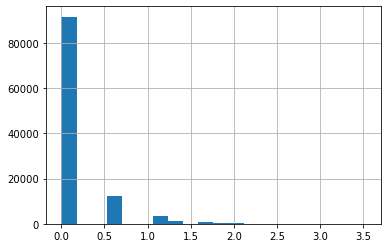

Числовой признак "score_bki":
count    73799.000000
mean        -1.904724
std          0.498231
min         -3.624586
25%         -2.259534
50%         -1.920823
75%         -1.569831
max          0.199773
Name: score_bki, dtype: float64


C:\Users\Dimon\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


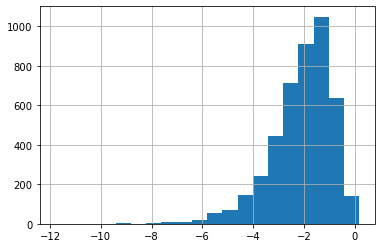

Числовой признак "bki_request_cnt":
count    73799.000000
mean         2.000339
std          2.252073
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         53.000000
Name: bki_request_cnt, dtype: float64


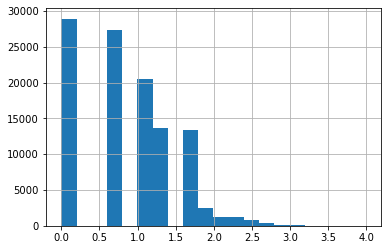

Числовой признак "region_rating":
count    73799.000000
mean        56.725701
std         13.055717
min         20.000000
25%         50.000000
50%         50.000000
75%         60.000000
max         80.000000
Name: region_rating, dtype: float64


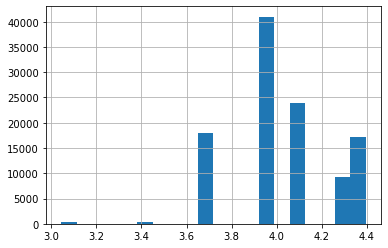

Числовой признак "income":
count      73799.000000
mean       41099.775417
std        46166.322400
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64


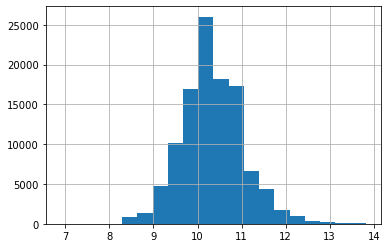

Числовой признак "per_of_def":
count    73799.000000
mean         0.126994
std          0.020828
min          0.076596
25%          0.115489
50%          0.129464
75%          0.140306
max          0.203252
Name: per_of_def, dtype: float64


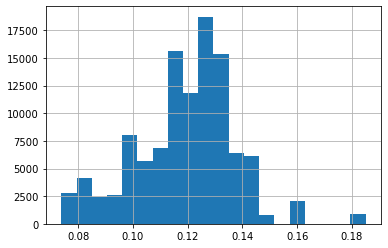

Числовой признак "num_of_app":
count    73799.000000
mean      1003.073212
std        235.056937
min         56.000000
25%        848.000000
50%       1071.000000
75%       1173.000000
max       1491.000000
Name: num_of_app, dtype: float64


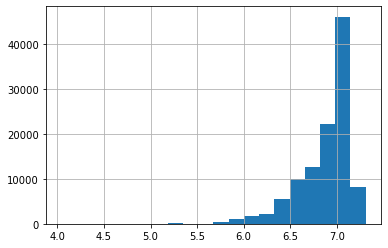

In [103]:
# посмотрим на распределение логарифмов признаков
# рассматриваем для датасета train
for col in num_cols:
    print('Числовой признак "{a}":'.format(a=col)) # выводим название признака
    print(data[col][data['train'] == 1].describe())
    # выводим распределение заемщиков по признакам
    np.log(data[col] + 1).hist(bins=20)
    plt.show()

Числовой признак "age":
count    73799.000000
mean        39.280641
std         11.520378
min         21.000000
25%         30.000000
50%         37.000000
75%         48.000000
max         72.000000
Name: age, dtype: float64


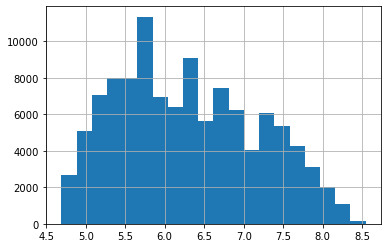

Числовой признак "decline_app_cnt":
count    73799.000000
mean         0.275749
std          0.804272
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         33.000000
Name: decline_app_cnt, dtype: float64


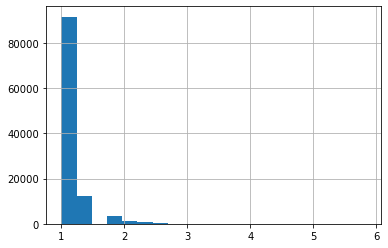

Числовой признак "score_bki":
count    73799.000000
mean        -1.904724
std          0.498231
min         -3.624586
25%         -2.259534
50%         -1.920823
75%         -1.569831
max          0.199773
Name: score_bki, dtype: float64


C:\Users\Dimon\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


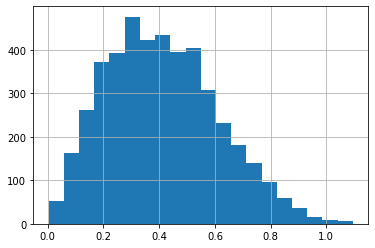

Числовой признак "bki_request_cnt":
count    73799.000000
mean         2.000339
std          2.252073
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         53.000000
Name: bki_request_cnt, dtype: float64


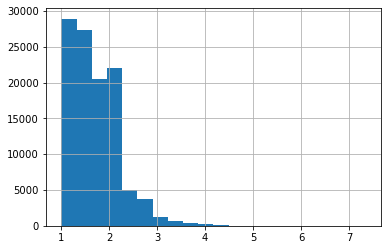

Числовой признак "region_rating":
count    73799.000000
mean        56.725701
std         13.055717
min         20.000000
25%         50.000000
50%         50.000000
75%         60.000000
max         80.000000
Name: region_rating, dtype: float64


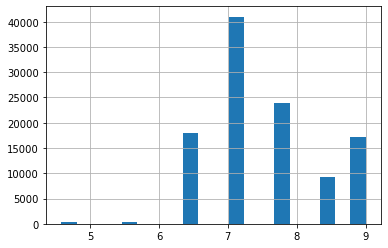

Числовой признак "income":
count      73799.000000
mean       41099.775417
std        46166.322400
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64


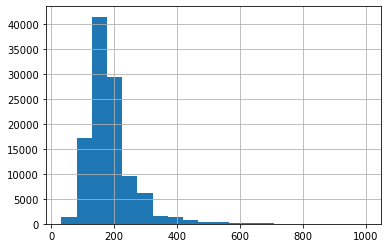

Числовой признак "per_of_def":
count    73799.000000
mean         0.126994
std          0.020828
min          0.076596
25%          0.115489
50%          0.129464
75%          0.140306
max          0.203252
Name: per_of_def, dtype: float64


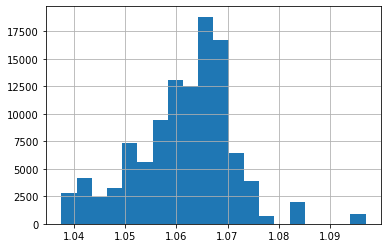

Числовой признак "num_of_app":
count    73799.000000
mean      1003.073212
std        235.056937
min         56.000000
25%        848.000000
50%       1071.000000
75%       1173.000000
max       1491.000000
Name: num_of_app, dtype: float64


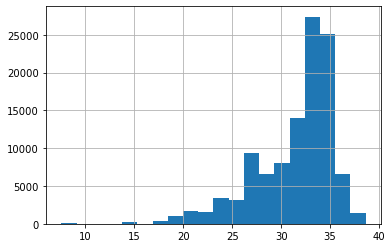

In [104]:
# посмотрим на распределение квадратных корней из признаков
# рассматриваем для датасета train
for col in num_cols:
    print('Числовой признак "{a}":'.format(a=col)) # выводим название признака
    print(data[col][data['train'] == 1].describe())
    # выводим распределение заемщиков по признакам
    np.sqrt(data[col] + 1).hist(bins=20)
    plt.show()

Видим, что для признаков "age", "bki_request_cnt", "income" распределение логарифов более нормальное.
Поэтому заменим значения этих признаков в датасете на логарифмы.
Признаки "decline_app_cnt", "score_bki" и "region_rating" оставим без изменений - 
логарифмирование и извлечение квадратного корня не делают распределение более нормальным.

In [105]:
# замену производим для всего датасета data
data['age'] = np.log(data['age'] + 1)
data['bki_request_cnt'] = np.log(data['bki_request_cnt'] + 1)
data['income'] = np.log(data['income'] + 1)

Числовой признак "age":
count    110148.000000
mean          3.654546
std           0.285054
min           3.091042
25%           3.433987
50%           3.637586
75%           3.891820
max           4.290459
Name: age, dtype: float64


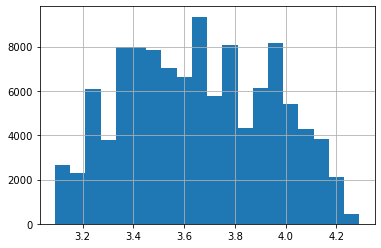

Числовой признак "decline_app_cnt":
count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64


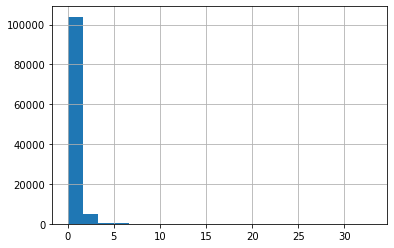

Числовой признак "score_bki":
count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64


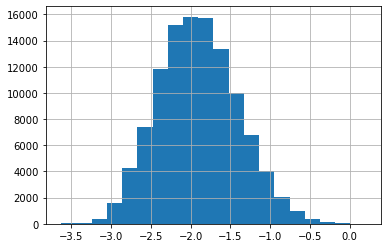

Числовой признак "bki_request_cnt":
count    110148.000000
mean          0.878752
std           0.658667
min           0.000000
25%           0.000000
50%           0.693147
75%           1.386294
max           3.988984
Name: bki_request_cnt, dtype: float64


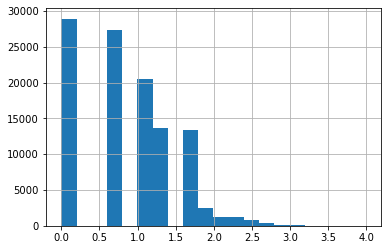

Числовой признак "region_rating":
count    110148.000000
mean         56.751189
std          13.065923
min          20.000000
25%          50.000000
50%          50.000000
75%          60.000000
max          80.000000
Name: region_rating, dtype: float64


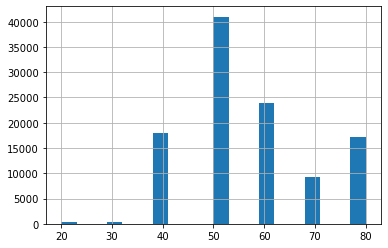

Числовой признак "income":
count    110148.000000
mean         10.345792
std           0.696636
min           6.908755
25%           9.903538
50%          10.308986
75%          10.778977
max          13.815512
Name: income, dtype: float64


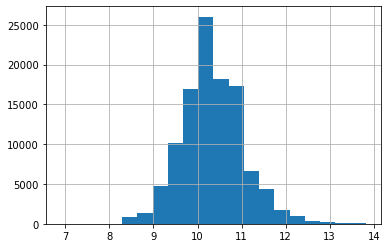

Числовой признак "per_of_def":
count    110148.000000
mean          0.127022
std           0.020775
min           0.076596
25%           0.115489
50%           0.129464
75%           0.140306
max           0.203252
Name: per_of_def, dtype: float64


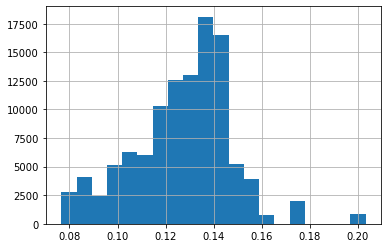

Числовой признак "num_of_app":
count    110148.000000
mean       1002.761267
std         234.959584
min          56.000000
25%         848.000000
50%        1071.000000
75%        1173.000000
max        1491.000000
Name: num_of_app, dtype: float64


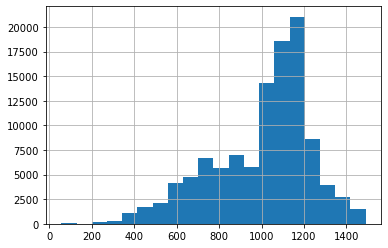

In [106]:
# посмотрим на распределения получишихся признаков
# смотрим для всего датасета data
for col in num_cols:
    print('Числовой признак "{a}":'.format(a=col)) # выводим название признака
    print(data[col].describe())
    # выводим распределение заемщиков по признакам
    data[col].hist(bins=20)
    plt.show()

In [107]:
# посчитаем выбросы для каждого признака
# считаем для всего датасета data
for col in num_cols:
    print('Числовой признак "{a}":'.format(a=col)) # выводим название признака
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    left = Q1 - 1.5*IQR
    right = Q3 + 1.5*IQR
    print('Количество выбросов: ', data[col][(data[col] < left) | (data[col] > right)].count())
    print('\n')

Числовой признак "age":
Количество выбросов:  0


Числовой признак "decline_app_cnt":
Количество выбросов:  18677


Числовой признак "score_bki":
Количество выбросов:  518


Числовой признак "bki_request_cnt":
Количество выбросов:  15


Числовой признак "region_rating":
Количество выбросов:  17917


Числовой признак "income":
Количество выбросов:  2609


Числовой признак "per_of_def":
Количество выбросов:  1564


Числовой признак "num_of_app":
Количество выбросов:  1281




Выводы по рассмотрению гистограмм и определению  выбросов:
на самом деле, выбросы, которые мы определили, таковыми могут не являться - 
по физическому смыслу признаки могут принимать такие значения.
На данном этапе удалять выбросы из датасета не будем.

# **Оценка значимости признаков**

**Преобразования бинарных признаков**

In [108]:
# посмотрим детальнее, какие данные хранятся в бинарных признаках
data[bin_cols]

,sex,car,car_type,good_work,foreign_passport
0,M,Y,Y,0,N
1,F,N,N,0,N
2,M,Y,N,0,Y
3,F,N,N,0,N
4,M,N,N,1,Y
...,...,...,...,...,...
110143,F,N,N,0,N
110144,F,Y,Y,0,N
110145,M,N,N,0,N
110146,F,N,N,0,N


In [109]:
# преобразуем даные с помощью метода fit класса LabelEncoder
# работаем со всем датасетом data
label_encoder = LabelEncoder()
for col in bin_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [110]:
# проверим
data[bin_cols].head()

,sex,car,car_type,good_work,foreign_passport
0,1,1,1,0,0
1,0,0,0,0,0
2,1,1,0,0,1
3,0,0,0,0,0
4,1,0,0,1,1


**Преобразования категориальных признаков**

In [111]:
# посмотрим детальнее, какие данные хранятся в категориальных признаках
data[cat_cols]

,education,home_address,work_address,sna,first_time
0,SCH,1,2,4,1
1,SCH,2,3,4,1
2,SCH,1,2,1,4
3,SCH,2,3,1,3
4,GRD,2,3,1,4
...,...,...,...,...,...
110143,SCH,2,3,4,1
110144,GRD,1,2,1,4
110145,GRD,1,2,4,2
110146,UGR,2,3,1,1


In [112]:
# преобразуем признак "education"
# работаем со всем датасетом data
label_encoder = LabelEncoder()
data['education'] = label_encoder.fit_transform(data['education'])

In [113]:
# проверим преобразования
data[cat_cols]

,education,home_address,work_address,sna,first_time
0,3,1,2,4,1
1,3,2,3,4,1
2,3,1,2,1,4
3,3,2,3,1,3
4,1,2,3,1,4
...,...,...,...,...,...
110143,3,2,3,4,1
110144,1,1,2,1,4
110145,1,1,2,4,2
110146,4,2,3,1,1


**Оценка корреляций**

<AxesSubplot:>

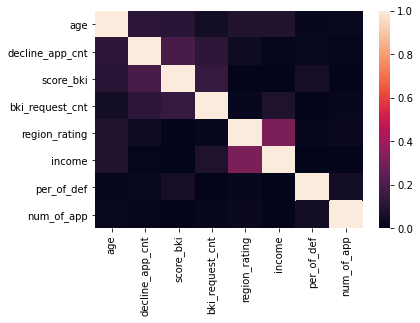

In [114]:
# оценим корреляцию с помощью матрицы корреляции 
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

Выводы:
* 1.Признаки слабо коррелированы между собой
* 2.Все признаки будем использовать в модели

<AxesSubplot:>

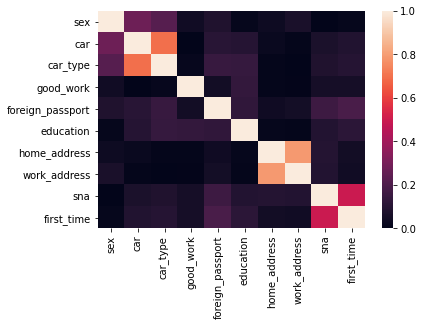

In [115]:
# оценим корреляцию Спирмана для нечисловых признаков
sns.heatmap(data[bin_cols + cat_cols].corr(method='spearman').abs(), vmin=0, vmax=1)

Выводы:
* 1.Высокая коррекляция car и car_type. В модели будем использовать car_type.
* 2.Высокая корреляция home_address и work_address. В модели будем использовать home_address.

In [116]:
# оставим бинарные и категориальные признаки, которые будут использоваться в модели
bin_cols = ['sex', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'sna', 'first_time']

**Оценка значимости числовых признаков**

<AxesSubplot:>

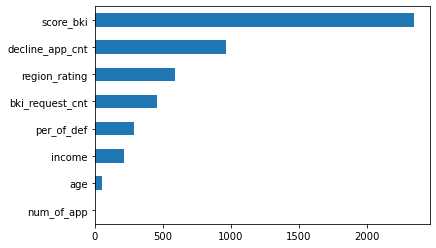

In [117]:
# проверяем значимость признаков
# работаем с записями из датасета train
imp_num = pd.Series(f_classif(data[data['train'] == 1][num_cols],
                              data[data['train'] == 1]['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Как и ожидалось, самый важный признак - 'score_bki'.


**Оценка значимости категориальных и бинарных признаков**

<AxesSubplot:>

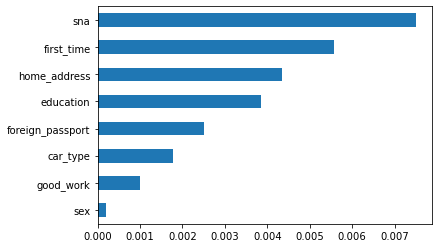

In [118]:
# проверяем значимость признаков
# работаем с записями из датасета train
imp_cat = Series(mutual_info_classif(data[data['train'] == 1][bin_cols + cat_cols], data[data['train'] == 1]['default'],
                                     discrete_features = True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Самый важный признак - 'sna'. Наименее важный - 'sex' не важен. Все признаки будем использовать в модели.

# **Строим модель**

In [119]:
# выделяем тренировочный датасет из датасета data
data_train = data[data['train'] == 1]
data_train = data_train.drop(['client_id', 'app_date', 'train'], axis=1)

In [120]:
# проверяем тренировочный датасет
data_train.head()

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,num_of_app,per_of_def
0,3,1,4.143135,1,1,0,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0,794,0.116236
1,3,0,4.094345,0,0,0,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0,1110,0.119403
2,3,1,3.258097,1,0,2,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0,794,0.116236
3,3,0,3.988984,0,0,0,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0,1060,0.173542
4,1,1,3.891820,0,0,0,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0,981,0.078669


In [121]:
# преобразуем категориальные признаки методом One-Hot Encoding
data_train_cat = OneHotEncoder(sparse = False).fit_transform(data_train[cat_cols].values)
#Воспользуемся методом One-Hot Encoding для преобразования категориальных переменных
#X_cat = OneHotEncoder(sparse = False).fit_transform(df_train[cat_cols].values)

In [122]:
# проверяем
data_train_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [123]:
# стандартизируем числовые признаки
data_train_num = StandardScaler().fit_transform(data_train[num_cols].values)
# Стандартизация числовых переменных
#X_num = StandardScaler().fit_transform(df_train[num_cols].values)

In [170]:
# проверяем
data_train_num

array([[ 1.71113664, -0.34285766, -0.2087987 , ..., -0.78501579,
        -0.51650253, -0.88946377],
       [ 1.5399884 , -0.34285766,  0.74754461, ..., -0.70752611,
        -0.36445207,  0.45490047],
       [-1.39343857,  2.14387966,  0.99669566, ..., -0.05288771,
        -0.51650253, -0.88946377],
       ...,
       [-0.66507223, -0.34285766,  0.78696739, ...,  0.5282444 ,
        -1.73254563, -0.03860032],
       [-0.89146325, -0.34285766,  0.85380611, ..., -1.25140899,
         2.34635007, -2.36571184],
       [-0.35072683, -0.34285766,  0.28102087, ..., -0.31419734,
         2.2349535 ,  0.24218461]])

In [169]:
# объединяем категориальные, бинарные, числовые признаки в одно признаковое пространство
X = np.hstack([data_train_num, data_train[bin_cols].values, data_train_cat])
y = data_train['default'].values

# Объединим признаки и делим на целевую и переменную.
#X = np.hstack([X_num, df_train[bin_cols].values, X_cat])
#Y = df_train['default'].values
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [126]:
# Разобьем данные для обучения и тестирования
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [180]:
# строим модель
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# **Оценка качества модели**

<AxesSubplot:>

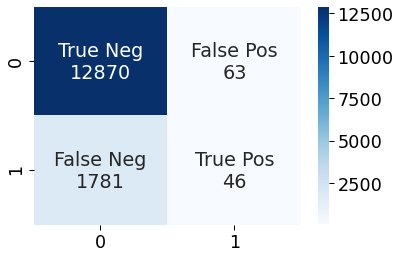

In [181]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

Полученная модель плохо предсказывает заемщиков, которые в будущем могут не выплачить кредиты.

**ROC-анализ**

In [160]:
# считаем метрики обучающей (X_train, y_train) выборки
y_train_probs = model.predict_proba(X_train)
y_train_probs = y_train_probs[:,1]
fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_train_probs)
roc_auc_train = roc_auc_score(y_train, y_train_probs)

In [129]:
# считаем метрики тестовой (X_test, y_test) выборки
y_test_probs = model.predict_proba(X_test)
y_test_probs = y_test_probs[:,1]
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_test_probs)
roc_auc_test = roc_auc_score(y_test, y_test_probs)

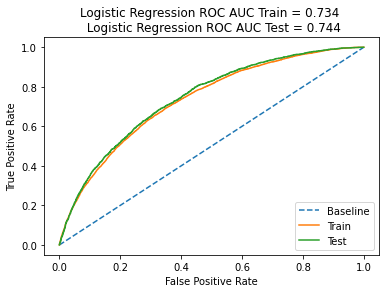

In [130]:
# строим графики метрик
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle = '--')
plt.plot(fpr_train, tpr_train, label = 'Train')
plt.plot(fpr_test, tpr_test, label = 'Test')
plt.title('Logistic Regression ROC AUC Train = {a} \n Logistic Regression ROC AUC Test = {b}'
          .format(a = roc_auc_train.round(3), b = roc_auc_test.round(3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Значения различаются не сильно, переобучения нет.
Посмотрим, можно ли найти более оптимальные параметры для модели.

# **Поиск оптимальных значений гиперпараметров**

In [131]:
# импорт библиотеки
from sklearn.model_selection import GridSearchCV

In [132]:
# ищем оптимальные значения гиперпараметров
model = LogisticRegression()
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']} 
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
## печатаем параметры
best_parameters = model.get_params()
for param_name in best_parameters:
        print(param_name, best_parameters[param_name], '\n')

C:\Users\Dimon\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.34184557        nan
 0.34184557        nan 0.05733592 0.05733592        nan 0.05733592
 0.05733592 0.05733592 0.05733592        nan 0.05733592 0.05733592
 0.34175679 0.34176811 0.34175679 0.34176811 0.34174636 0.34175679
 0.34176811 0.34175679 0.34175679 0.34174636 0.05756818 0.05756818
 0.05756818 0.05732859 0.05756818 0.05756818 0.05756818 0.05732859
 0.34177969 0.34175679 0.34177969 0.34179114 0.34177969 0.34175679
 0.34177969 0.34179114]
  warnings.warn(


C 1.0 

class_weight balanced 

dual False 

fit_intercept True 

intercept_scaling 1 

l1_ratio None 

max_iter 100 

multi_class auto 

n_jobs None 

penalty l1 

random_state None 

solver liblinear 

tol 0.0001 

verbose 0 

warm_start False 



Строим модель с подобранными гиперпарметрами

In [133]:
# Разобьем данные для обучения и тестирования по новой
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [177]:
# строим модель
new_model = LogisticRegression(random_state = None, 
                               C = 1, 
                               class_weight = 'balanced', 
                               dual = False, 
                               fit_intercept = True, 
                               intercept_scaling = 1, 
                               l1_ratio = None, 
                               max_iter = 100, 
                               multi_class = 'auto', 
                               n_jobs = None, 
                               penalty = 'l1', 
                               solver = 'liblinear', 
                               tol = 0.0001,
                               verbose = 0, 
                               warm_start = False)
new_model.fit(X_train, y_train)

y_pred = new_model.predict(X_test)

<AxesSubplot:>

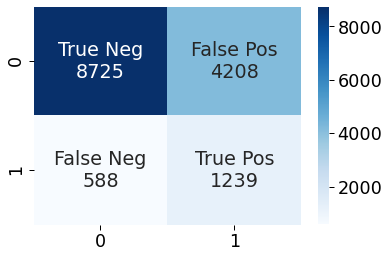

In [178]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

Эта модель лучше предсказывает неблагонадежных клиентов.

**ROC-анализ**

In [135]:
# считаем метрики обучающей (X_train, y_train) выборки
y_train_probs = new_model.predict_proba(X_train)
y_train_probs = y_train_probs[:,1]
fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_train_probs)
roc_auc_train = roc_auc_score(y_train, y_train_probs)

In [136]:
# считаем метрики тестовой (X_test, y_test) выборки
y_test_probs = new_model.predict_proba(X_test)
y_test_probs = y_test_probs[:,1]
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_test_probs)
roc_auc_test = roc_auc_score(y_test, y_test_probs)


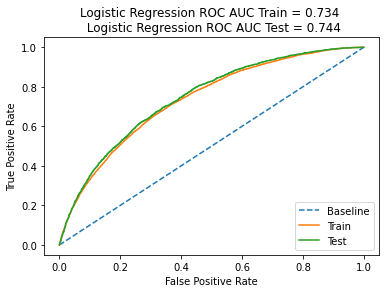

In [137]:
# строи графики метрик
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle = '--')
plt.plot(fpr_train, tpr_train, label = 'Train')
plt.plot(fpr_test, tpr_test, label = 'Test')
plt.title('Logistic Regression ROC AUC Train = {a} \n Logistic Regression ROC AUC Test = {b}'
          .format(a = roc_auc_train.round(3), b = roc_auc_test.round(3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

**Вывод: расхождение метрики ROC AUC для обучающей и тестовоый выборок не изменилось.
Будем использовать модель с подобранными гиперпараметрами.
После обработки датасета и добавления новых признаков была сгенерирована базовая модель логистической регрессии, которая показала ROC AUC > 0.74
Модель была донастроена с подбором параметров через GridSearchCV.
Для дальнейшего усовершенствования модели может быть необходимо создать новые признаки или придумать какие-либо решения со значениями, которые вызывают сомнение в рамках IQR.**

# **Определяем значение дефолта клиентов**

In [138]:
# выделяем тестовый датасет из датасета data
data_test = data[data['train'] == 0]
data_test = data_test.drop(['client_id', 'app_date', 'train'], axis=1)

In [139]:
# преобразуем категориальные признаки методом One-Hot Encoding
data_test_cat = OneHotEncoder(sparse = False).fit_transform(data_test[cat_cols].values)

In [140]:
# проверяем
data_test_cat

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [141]:
# стандартизируем числовые признаки
data_test_num = StandardScaler().fit_transform(data_test[num_cols].values)

In [142]:
# проверяем
data_test_num

array([[-0.88333898, -0.33995109, -0.73288746, ...,  0.68282058,
         0.4450004 , -0.99730532],
       [ 0.12606863,  6.00146439,  0.79551047, ..., -2.63253397,
        -0.56077739,  0.35300684],
       [ 0.97850869, -0.33995109,  0.42413578, ..., -0.05272498,
         0.31650603, -1.33807811],
       ...,
       [-0.65688874,  2.1966151 ,  1.92005304, ...,  0.9453502 ,
         0.26864856, -1.19324967],
       [-1.12541848,  0.92833201,  1.31888606, ..., -0.05272498,
         3.40089756, -2.78210279],
       [ 0.0372345 , -0.33995109,  0.79042787, ..., -1.05077617,
         0.70270711,  1.4818167 ]])

In [143]:
# объединяем категориальные, бинарные, числовые признаки в одно признаковое пространство
X = np.hstack([data_test_num, data_test[bin_cols].values, data_test_cat])

In [144]:
# делаем расчет
y = new_model.predict_proba(X)
y = y[:,1]

In [145]:
# создаем новый датасет
submit = pd.DataFrame(test.client_id)

In [146]:
# включаем в датасет расчитанные значения признака default
submit['default'] = y


In [147]:
# выгружаем получившийся датасет в файл
submit.to_csv('submission.csv', index=False)

In [148]:
submit.sample(10)

,client_id,default
6173,54575,0.383172
1844,38801,0.620837
8565,75170,0.818567
29090,53894,0.433468
33431,49405,0.616987
29244,22655,0.448139
29895,80604,0.121206
26321,13964,0.817868
27029,3625,0.335293
22462,16096,0.365108
